# I - Fluxonium Qubit using SCQubits

In [3]:
import scqubits as sc

In [4]:
fluxonium = sc.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.33, cutoff=110)

In [5]:
evals_scqubits = fluxonium.eigenvals()
evals_scqubits -= evals_scqubits[0]
evals_scqubits

array([ 0.        ,  3.07117603, 10.22186116, 13.86175133, 15.0706719 ,
       19.43152268])

# II - Fluxonium Qubit using QuTiP

In [6]:
import qutip as qt
import numpy as np

We have the following Hamiltonian for the circuit (that can be found by wrinting the lagrangian, etc.) :

$$
H = \frac 1 {2C} q^2 + \frac 1 {2L} \phi^2 - \frac {\phi_0^2} {L_C} \cos \bigg(\frac \phi {\phi_0} \bigg)
$$

Where $$q = C\dot\phi$$ $$\phi_0 = \frac \hbar {2e}$$

If we now replace $C$ and $L$ with $C = \frac {e^2} {2E_C}$ and $L = \frac {\phi_0^2} {E_L}$, and use $E_J = \frac {\phi_0^2} {L_C}$, we get the following expression :

$$
H = \frac {E_C} {e^2} q^2 + \frac {E_L} {2\phi_0^2} \phi^2 - E_J \cos \bigg(\frac \phi {\phi_0} \bigg)
$$

Let us define :
$$\hat n := \frac {\hat q} {2e}$$
$$\hat \varphi := \frac {\hat \phi} {\phi_0}$$

So that : 
$$
\hat H = 4E_C \hat n^2 + \frac {E_L} 2 \hat\varphi^2 - E_J \cos (\hat \varphi )
$$

Finally, let us define the destruction operator :
$$ \hat a := \frac 1 2 \bigg(\frac {E_L} {2E_C}\bigg)^{\frac 1 4}\hat\varphi + i\bigg(\frac {2E_C} {E_L} \bigg)^{\frac 1 4}\hat n $$

If we define $\varepsilon := \big(\frac {E_L} {2E_C}\big)^{\frac 1 4}$, this boils down to :
$$ \hat a = \frac 1 2 \varepsilon\hat\varphi + i\frac 1 {\varepsilon}\hat n $$

We then have, since $[\hat \varphi, \hat n] = i$ $$[\hat a, \hat a^\dagger] = 1$$

And the Hamiltonian can be rewritten as :
$$
\hat H = \hbar \omega \bigg(\hat a^\dag \hat a + \frac 1 2\bigg) - E_J \cos \bigg( \frac 1 \varepsilon (\hat a + \hat a^\dag) \bigg)
$$

as $\hbar\omega = \sqrt{8E_CE_L}$ if $\omega = \frac 1 {\sqrt{LC}}$.

This is the formula that we will implement. If we wish, we can also add an external flux $\varphi_{ext}$ between $0$ and $2\pi$ inside the cosinus.

In [7]:
def hamiltonian_qutip(EL, EC, EJ, flux=0, truncation_level=110):
    """
    A simple funciton that returns the hamiltonian of a fluxonium circuit
    """

    creation = qt.create(truncation_level)  # Creation and destruction operators
    destruction = qt.destroy(truncation_level)

    epsilon = (EL / (2 * EC)) ** (1 / 4)

    return (
        np.sqrt(8 * EC * EL) * (creation * destruction + 1 / 2)
        - EJ * ((creation + destruction) / epsilon - 2 * np.pi * flux).cosm()
    )

In [8]:
evals_qutip = hamiltonian_qutip(0.5, 2.5, 8.9, flux=0.33).eigenenergies()
evals_qutip -= evals_qutip[0]
evals_qutip

array([  0.        ,   3.07117603,  10.22186116,  13.86175133,
        15.0706719 ,  19.43152268,  23.10001985,  24.5225043 ,
        27.38550729,  31.19196545,  34.67916196,  38.2421008 ,
        42.00611724,  45.56048236,  48.02056967,  50.68204386,
        54.10033469,  57.47920593,  60.59832288,  63.16414362,
        65.67582887,  68.7798961 ,  72.07359668,  75.38953027,
        78.75404313,  82.19544064,  85.68884314,  89.18706234,
        92.63008173,  95.90915149,  98.87142029, 101.66472731,
       104.67453717, 107.86424612, 111.08668364, 114.27082398,
       117.35856241, 120.27601436, 123.0697852 , 125.95959874,
       129.02016949, 132.1838629 , 135.40156448, 138.66051989,
       141.96002078, 145.29607418, 148.65927609, 152.0372591 ,
       155.41559349, 158.77505153, 162.08883867, 165.31936119,
       168.43214601, 171.44250436, 174.44209215, 177.50710157,
       180.63569483, 183.79472119, 186.95590759, 190.0962181 ,
       193.19420755, 196.22688932, 199.20195644, 202.15

# III - Fluxonium Qubit using Numpy

In [9]:
import numpy.linalg as alg
from scipy.linalg import cosm

Here, we will use the fact that the eigenvalues of $\hat H$ can be explored using the jump operators, meaning that $\hat a |n\rangle$ is associated to the eigenvalue $n-1$, and $\hat a^\dag |n\rangle$ to the eigenvalue $n+1$

We have :
$$
\begin{aligned}
\|\hat a | n \rangle \|^2 & = \langle n | \hat a^\dag \hat a | n \rangle \\
& = \langle n |n| n \rangle \\
& = n
\end{aligned}
$$
Same goes for the other one.
Therefore, if we normalize $\hat a |n\rangle$ and $\hat a^\dag |n\rangle$, we get the relationships :

$$
\begin{equation}
    \begin{cases}
        \hat a |n\rangle = \sqrt n | n-1 \rangle \\
        \hat a^\dag |n\rangle= \sqrt {n+1} | n+1 \rangle
    \end{cases}\,.
\end{equation}
$$

From these relationships we obtain the form of the $\hat a$ and $\hat a^\dag$ matrices, truncated to order $d$, in the Fock basis.

In [10]:
def hamiltonian_numpy(EL, EC, EJ, flux=0, truncation_level=110):
    """
    A simple funciton that returns the hamiltonian of a fluxonium circuit
    """

    destruction_np = np.zeros((truncation_level, truncation_level))

    for n in range(1, truncation_level):
        destruction_np[n - 1, n] = np.sqrt(n)

    creation_np = destruction_np.T  # Since it is a real matrix in the Fock basis.

    epsilon = (EL / (2 * EC)) ** (1 / 4)

    return np.sqrt(8 * EC * EL) * (
        np.dot(creation_np, destruction_np) + np.eye(truncation_level) * 1 / 2
    ) - EJ * cosm(
        (creation_np + destruction_np) / epsilon
        - 2 * np.pi * flux * np.eye(truncation_level)
    )

In [11]:
evals_numpy = np.sort(alg.eigvals(hamiltonian_numpy(0.5, 2.5, 8.9)))
evals_numpy -= evals_numpy[0]
evals_numpy

array([  0.        ,   8.75844526,   8.97955262,  11.00203435,
        16.93299002,  19.57185963,  23.15002884,  27.70870397,
        31.70268214,  34.76565983,  36.03701914,  37.72943458,
        40.99428963,  44.27996731,  47.37513765,  50.59527123,
        54.07646371,  57.69297526,  61.35602692,  65.05558755,
        68.76242336,  72.39813185,  75.81737225,  78.75812995,
        81.04802062,  83.15842762,  85.70321504,  88.63628456,
        91.68592589,  94.76946121,  97.9131342 , 101.14349971,
       104.4553389 , 107.82971847, 111.25217189, 114.71407427,
       118.20689999, 121.71869942, 125.23361895, 128.73116866,
       132.18349262, 135.54997248, 138.77100414, 141.77216412,
       144.51315529, 147.08059436, 149.67060105, 152.41485406,
       155.3066936 , 158.28964551, 161.32958524, 164.41713178,
       167.55381796, 170.7391154 , 173.96895658, 177.23854661,
       180.54287835, 183.87722083, 187.23804645, 190.61988048,
       194.020645  , 197.4267805 , 200.84567898, 204.24

# IV - Comparaison

In [12]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [13]:
def compute_energies(
    EL,
    EC,
    EJ,
    start_flux=-np.pi / 6,
    end_flux=np.pi / 6,
    nbpoints=100,
    truncation_level=110,
    nblevels=6,
):
    Phases = np.linspace(start_flux, end_flux, nbpoints)
    Energies = np.empty((3, nblevels, Phases.size))

    for i, phase in enumerate(Phases):
        evals_numpy = np.sort(
            alg.eigvals(
                hamiltonian_numpy(
                    EL, EC, EJ, flux=phase, truncation_level=truncation_level
                )
            )
        )
        Energies[0, :, i] = evals_numpy[:nblevels] - evals_numpy[0]

        evals_qutip = hamiltonian_qutip(
            EL, EC, EJ, flux=phase, truncation_level=truncation_level
        ).eigenenergies()
        Energies[1, :, i] = evals_qutip[:nblevels] - evals_qutip[0]

        evals_scqubits = sc.Fluxonium(
            EJ=EJ,
            EC=EC,
            EL=EL,
            flux=phase,
            cutoff=truncation_level,
            truncated_dim=nblevels,
        ).eigenvals()
        Energies[2, :, i] = evals_scqubits[:nblevels] - evals_scqubits[0]

    return Phases, Energies

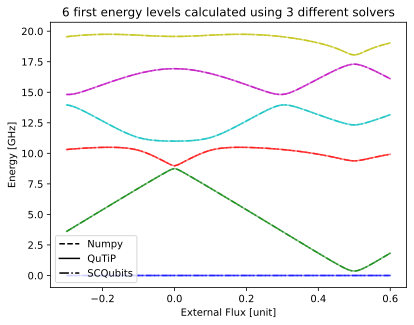

In [14]:
nblevels = 6

Phases, Energies = compute_energies(
    0.5, 2.5, 8.9, -0.3, 0.6, truncation_level=110, nblevels=nblevels
)

Colors = ["b", "g", "r", "c", "m", "y"]

for i in range(nblevels):
    plt.plot(Phases, Energies[0, i, :], linestyle="--", c=Colors[i], alpha=0.5)
    plt.plot(Phases, Energies[1, i, :], linestyle="-", c=Colors[i], alpha=0.5)
    plt.plot(Phases, Energies[2, i, :], linestyle="-.", c=Colors[i], alpha=0.5)


plt.legend(
    handles=[
        mlines.Line2D([], [], color="black", linestyle="--", label="Numpy"),
        mlines.Line2D([], [], color="black", linestyle="-", label="QuTiP"),
        mlines.Line2D([], [], color="black", linestyle="-.", label="SCQubits"),
    ]
)
plt.title(f"{nblevels} first energy levels calculated using 3 different solvers")
plt.xlabel("External Flux [unit]")
plt.ylabel("Energy [GHz]")

plt.show()

**Conclusion** : The solvers overlap almost perfectly for the first 6 energy levels.

# V - Convergence

In [15]:
def compute_energies_dim(EL, EC, EJ, flux=0, start_dim=10, end_dim=120, nblevels=5):
    Dims = np.arange(start_dim, end_dim)
    Energies = np.empty((3, nblevels, Dims.size))

    for i, dim in enumerate(Dims):
        evals_numpy = np.sort(
            alg.eigvals(hamiltonian_numpy(EL, EC, EJ, flux=flux, truncation_level=dim))
        )
        Energies[0, :, i] = evals_numpy[1 : nblevels + 1] - evals_numpy[0]

        evals_qutip = hamiltonian_qutip(
            EL, EC, EJ, flux=flux, truncation_level=dim
        ).eigenenergies()
        Energies[1, :, i] = evals_qutip[1 : nblevels + 1] - evals_qutip[0]

        evals_scqubits = sc.Fluxonium(
            EJ=EJ, EC=EC, EL=EL, flux=flux, cutoff=dim
        ).eigenvals()
        Energies[2, :, i] = evals_scqubits[1 : nblevels + 1] - evals_scqubits[0]

    for i in range(nblevels):
        Energies[0, i, :] = np.abs(Energies[0, i, :] - Energies[0, i, -1])
        Energies[1, i, :] = np.abs(Energies[1, i, :] - Energies[1, i, -1])
        Energies[2, i, :] = np.abs(Energies[2, i, :] - Energies[2, i, -1])

    return Dims, Energies

[Text(0.5, 1.0, 'Energy levels 1 to 5 calculated using 3 different solvers'),
 Text(0.5, 0, 'Truncation Level [Unit]'),
 Text(0, 0.5, 'Energy-Energy(max_dim) [GHz]'),
 None,
 None]

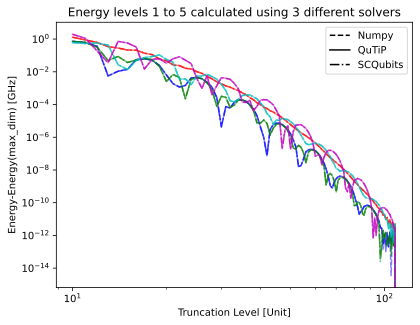

In [16]:
nblevels = 5

Dims, Energies = compute_energies_dim(
    0.5, 2.5, 8.9, start_dim=10, end_dim=110, nblevels=nblevels
)

Colors = ["b", "g", "r", "c", "m", "y"]

fig, ax = plt.subplots()

for i in range(nblevels):
    ax.plot(Dims, Energies[0, i, :], linestyle="--", c=Colors[i], alpha=0.5)
    ax.plot(Dims, Energies[1, i, :], linestyle="-", c=Colors[i], alpha=0.5)
    ax.plot(Dims, Energies[2, i, :], linestyle="-.", c=Colors[i], alpha=0.5)


plt.legend(
    handles=[
        mlines.Line2D([], [], color="black", linestyle="--", label="Numpy"),
        mlines.Line2D([], [], color="black", linestyle="-", label="QuTiP"),
        mlines.Line2D([], [], color="black", linestyle="-.", label="SCQubits"),
    ]
)

ax.set(
    title=f"Energy levels 1 to {nblevels} calculated using 3 different solvers",
    xlabel="Truncation Level [Unit]",
    ylabel="Energy-Energy(max_dim) [GHz]",
    xscale="log",
    yscale = 'log'
)

# VI - Graphical representation

To do this, we are going to express the eigenstates of the Hamiltonian $|\psi_j\rangle$ in the phase basis, as $\psi_j(\varphi) = \langle\varphi|\psi_j\rangle$. Since we chose to express the eigenvalues in the Fock basis, meaning:
$$|\psi_j\rangle = \sum_{m\leq d}c_m^{(j)} |\psi_m^{HO}\rangle$$
This means that :
$$\langle\varphi|\psi_j\rangle = \sum_{m\leq d}c_m^{(j)} \langle\varphi|\psi_m^{HO}\rangle$$
And we know the $\langle\varphi|\psi_m^{HO}\rangle$ terms as they have an explicit expression, which is :
$$
\psi_m^{HO}(\varphi) = \langle \varphi |\psi_m^{HO} \rangle
= \frac{1}{\sqrt{2^m m!}} \left(\frac{1}{\pi \varphi_{\rm zpf}^2}\right)^{1/4} 
H_m\!\left(\frac{\varphi}{\varphi_{\rm zpf}}\right) 
\exp\left[-\frac{\varphi^2}{2 \varphi_{\rm zpf}^2}\right]$$
Where :
$$
\varphi_{\rm zpf} = \left( \frac{2 E_C}{E_L} \right)^{1/4}.
$$

In [46]:
from scipy.special import hermite, factorial

In [ ]:
def SHO_wavefunc(m, Phases, EC, EL):
    phi_zpf = (2*EC / EL)**(1/4)

    prefactor = 1/np.sqrt(2**m * factorial(m, exact=False)) * (1/(np.pi*phi_zpf**2))**(1/4)

    return np.array([prefactor * hermite(m)(phase/phi_zpf) * np.exp(-1/2 * (phase/phi_zpf)**2) for phase in Phases])

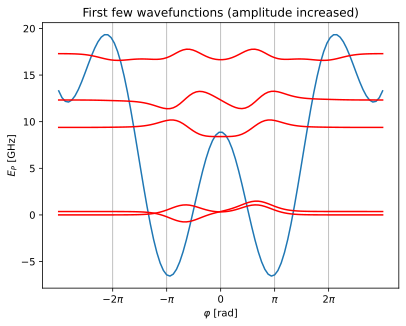

In [69]:
EL = 0.5
EJ = 8.9
EC = 2.5
flux = 0.5
truncation_level=110

nlevels = 5

Phases = np.linspace(-3*np.pi,3*np.pi,100)
V = [EL/2 * phase**2 - EJ*np.cos(phase-2*np.pi*flux) for phase in Phases]

fig,ax = plt.subplots()
ax.plot(Phases,V)

H = hamiltonian_numpy(EL,EC,EJ,flux, truncation_level=truncation_level)
evals,evecs = alg.eigh(H)
evals = evals[:nlevels]
evals -= evals[0]

evecs = evecs[:,:nlevels]

SHO_wavefunctions = np.array([SHO_wavefunc(m, Phases, EC, EL) for m in range(truncation_level)])

wavefunctions = np.array([[np.dot(SHO_wavefunctions[:,j], evecs[:,i]) for j in range(len(Phases))] for i in range(nlevels)])

for i,wavefunc in enumerate(wavefunctions):
    ax.plot(Phases,2*wavefunc+evals[i], color='r') #Amplitude increased to see better

# Custom radian ticks and tick labels
custom_ticks = [-2*np.pi,-np.pi,0, np.pi, 2*np.pi]
custom_tick_labels = [r'$-2\pi$',r'$-\pi$',r'$0$', r'$\pi$', r'$2\pi$']

ax.set(xticks=custom_ticks,
       xticklabels=custom_tick_labels,
       xlabel=r'$\varphi$ [rad]',
       ylabel = r'$E_P$ [GHz]',
       title = "First few wavefunctions (amplitude increased)")

plt.grid(axis='x')
plt.show()